## WFP-01-03-02 CHIRPS Rainfall Estimates (RFE) - Aggregations

 This application generates Rainfall Estimates (RFE) aggregations, from CHIRPS RFE 5km resolution, compared to a reference period.

### <a name="objective">Objective 

The objective of this code is to determine:
    - Sum of daily data over the past N days, derived every 10 days (N = 10, 30, 60, 90, 120, 150, 180, 270, 365 days)
    - Counts of daily data above 1mm over the past N days, derived every 10 days (N = 30, 60, 90 days).
    - Longest sequence of daily values < 2mm ("dry spell") within the last N days, derived every 10 days (N = 30, 60, 90 days).


### <a name="service">Service definition

In [1]:
service = dict([('title', 'CHIRPS Rainfall Estimates (RFE) - Aggregations'),
                ('abstract', 'TBD'),
                ('id', 'wfp-01-03-02')])

### <a name="runtime">Runtime parameter definition

**Input references**

This is the CHIRPS stack catalogue references

In [2]:
input_references = 'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.03.10'

In [3]:
N_10 = dict([('id', 'N_10'),
                          ('value', 'True'),
                          ('title', '10 Day Aggregation'),
                          ('abstract', 'Get a 10 day aggregation')])

In [4]:
N_30 = dict([('id', 'N_30'),
                          ('value', 'False'),
                          ('title', '30 Day Aggregation'),
                          ('abstract', 'Get a 30 day aggregation')])

In [5]:
N_60 = dict([('id', 'N_60'),
                          ('value', 'False'),
                          ('title', '60 Day Aggregation'),
                          ('abstract', 'Get a 60 day aggregation')])

In [6]:
N_90 = dict([('id', 'N_90'),
                          ('value', 'False'),
                          ('title', '90 Day Aggregation'),
                          ('abstract', 'Get a 90 day aggregation')])

In [7]:
N_120 = dict([('id', 'N_120'),
                          ('value', 'False'),
                          ('title', '120 Day Aggregation'),
                          ('abstract', 'Get a 120 day aggregation')])

In [8]:
N_150 = dict([('id', 'N_150'),
                          ('value', 'False'),
                          ('title', '150 Day Aggregation'),
                          ('abstract', 'Get a 150 day aggregation')])

In [9]:
N_180 = dict([('id', 'N_180'),
                          ('value', 'False'),
                          ('title', '180 Day Aggregation'),
                          ('abstract', 'Get a 180 day aggregation')])

In [10]:
N_270 = dict([('id', 'N_270'),
                          ('value', 'False'),
                          ('title', '270 Day Aggregation'),
                          ('abstract', 'Get a 270 day aggregation')])

In [11]:
N_365 = dict([('id', 'N_365'),
                          ('value', 'False'),
                          ('title', '365 Day Aggregation'),
                          ('abstract', 'Get a 365 day aggregation')])

In [12]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                          ('value', 'POLYGON ((26.832 9.5136, 28.6843 9.5136, 28.6843 7.8009, 26.832 7.8009, 26.832 9.5136))'),
                          ('title', 'WKT Polygon for the Region of Interest'),
                          ('abstract', 'Set the value of WKT Polygon')])

In [13]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value',  'Sudan'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

In [14]:
'''LTA_list = dict([('id', 'LTA_list'),
                ('value', ''),
                ('title', 'List of Long-time Averages'),
                ('abstract', 'List of LTAs to calculate Anomalies'),
                ('maxOccurs', '40')])
'''

"LTA_list = dict([('id', 'LTA_list'),\n                ('value', ''),\n                ('title', 'List of Long-time Averages'),\n                ('abstract', 'List of LTAs to calculate Anomalies'),\n                ('maxOccurs', '40')])\n"

### <a name="workflow">Workflow

#### Import the packages required for processing the data

In [15]:
from osgeo import gdal, ogr, osr
from geopandas import GeoDataFrame
import gzip
import cioppy
import shutil
import sys
import numpy as np
import pandas as pd
import math
import re
import os
sys.path.append(os.getcwd())
sys.path.append('/application/notebook/libexec/')
from aux_functions import matrix_sum, mask_matrix, crop_image, write_output_image, get_matrix_list
print(sys.path)

['', '/opt/anaconda/lib/python27.zip', '/opt/anaconda/lib/python2.7', '/opt/anaconda/lib/python2.7/plat-linux2', '/opt/anaconda/lib/python2.7/lib-tk', '/opt/anaconda/lib/python2.7/lib-old', '/opt/anaconda/lib/python2.7/lib-dynload', '/opt/anaconda/lib/python2.7/site-packages/Glymur-0.8.6-py2.7.egg', '/opt/anaconda/lib/python2.7/site-packages/click_plugins-1.0.3-py2.7.egg', '/opt/anaconda/lib/python2.7/site-packages/setuptools-23.0.0-py2.7.egg', '/opt/anaconda/lib/python2.7/site-packages', '/opt/anaconda/lib/python2.7/site-packages/PIL', '/opt/anaconda/lib/python2.7/site-packages/IPython/extensions', '/home/rirr/.ipython', '/workspace/wfp-01-03-02/src/main/app-resources/notebook/libexec', '/application/notebook/libexec/']


In [16]:
def get_info(row, search_params):
    search = ciop.search(end_point=row['catalogue_url'], 
                                  params=search_params,
                                  output_fields='identifier,startdate,enclosure',
                                  model='GeoTime')[0]
    
    series = pd.Series(search)
    
    series['startdate'] = pd.to_datetime(series['startdate'])
    
    return series

In [17]:
if isinstance(input_references, str):
    input_references = [input_references]
input_references = ['https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.03', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.02',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.01', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.05',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.04', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.06',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.07', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.08',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.09', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.10',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.11', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.12',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.13', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.14',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.15', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.16',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.17', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.18',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.19', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.20',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.21', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.22',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.23', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.24',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.25', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.26',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.27', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.28',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.29', 
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.30',
                   'https://catalog.terradue.com/chirps/search?format=atom&uid=chirps-v2.0.2017.05.31']
'''
test_lta = np.array([['', 'start_date', 'end_date', 'enclosure'],
                    ['1', '2015.04.01', '2017.04.10', 'LTA.CHIRPSv2.N10.days_total.2015.4.1.2017.4.10.tif'],
                    ['2', '2015.04.11', '2017.04.20', 'LTA.CHIRPSv2.N10.days_total.2015.4.11.2017.4.20.tif'],
                    ['3', '2015.04.21', '2017.04.30', 'LTA.CHIRPSv2.N10.days_total.2015.4.21.2017.4.30.tif'],
                    ['4', '2015.04.01', '2017.04.30', 'LTA.CHIRPSv2.N30.days_total.2015.4.1.2017.4.30.tif']])
'''

nameOfRegion = nameOfRegion['value']
#lta_data = GeoDataFrame(data=test_lta[1:,1:],
#                        index=test_lta[1:,0],
#                        columns=test_lta[0,1:])
#lta_data['start_date'] = pd.to_datetime(lta_data['start_date'])
#lta_data['end_date'] = pd.to_datetime(lta_data['end_date'])
#print(lta_data)
ciop = cioppy.Cioppy()

gpd_data = GeoDataFrame(input_references,
                       columns=['catalogue_url'])

region_of_interest = regionOfInterest['value']
gpd_data = gpd_data.sort_values(by='catalogue_url')
start_date = re.findall('\d{4}\.\d{2}\.\d{2}', gpd_data.iloc[0]['catalogue_url'])[0].replace('.', '-')
end_date = re.findall('\d{4}\.\d{2}\.\d{2}', gpd_data.iloc[-1]['catalogue_url'])[0].replace('.', '-')
print(start_date)
print(end_date)
print(len(input_references))
search_params =  dict([('start', start_date),
                      ('stop', end_date),
                      ('count', len(input_references))])
gpd_final = gpd_data.apply(lambda row: get_info(row, search_params), axis=1)
gpd_final.head()

#Insert code here to convert the LTA List to a Geopandas Data Frame
#lta_data = GeoDataFrame(LTA_list, columns=['catalogue_url'])

2017-05-01
2017-05-31
31


,enclosure,identifier,startdate
2,ftp://anonymous@ftp.chg.ucsb.edu/pub/org/chg/p...,chirps-v2.0.2017.05.01,2017-05-01
1,ftp://anonymous@ftp.chg.ucsb.edu/pub/org/chg/p...,chirps-v2.0.2017.05.02,2017-05-02
0,ftp://anonymous@ftp.chg.ucsb.edu/pub/org/chg/p...,chirps-v2.0.2017.05.03,2017-05-03
4,ftp://anonymous@ftp.chg.ucsb.edu/pub/org/chg/p...,chirps-v2.0.2017.05.04,2017-05-04
3,ftp://anonymous@ftp.chg.ucsb.edu/pub/org/chg/p...,chirps-v2.0.2017.05.05,2017-05-05


In [18]:
def get_lta_from_dataframe(dataframe, aggregation, start_day, end_day, start_month, end_month):
    dataframe_agr = dataframe[(dataframe['enclosure'].str.contains(aggregation))]
    return dataframe_agr[(dataframe_agr['start_date'].dt.day == start_day) & 
                     (dataframe_agr['start_date'].dt.month == start_month) & 
                     (dataframe_agr['end_date'].dt.day == end_day) & 
                     (dataframe_agr['end_date'].dt.month == end_month)]['enclosure'].tolist()

In [19]:
def calc_aggregations(product_list, N_value, region_of_interest):
    mask_no_data_value = 0
    sum_result = 0
    count_above_one = 0
    max_sequence = 0
    temp_mat = 0
    regions_below_two = 0
    projection = None
    geo_transform = None
    print(type(product_list))
    for chirp_product_url in product_list:
        # uncompressed data
        chirp_product = (chirp_product_url.split('/')[-1]).split('.gz')[0]
        print(chirp_product)
        cropped_product_path = 'crop_' + chirp_product
        try:
            crop_image(chirp_product_url, region_of_interest, cropped_product_path)
            # Read GeoTIFF as an array
            dataset = gdal.Open(cropped_product_path)
            product_array = dataset.GetRasterBand(1).ReadAsArray()
            no_data_value = dataset.GetRasterBand(1).ComputeRasterMinMax()[0]
            geo_transform = dataset.GetGeoTransform()
            projection = dataset.GetProjection()
            ## Create mask of no_data_values
            if isinstance(mask_no_data_value, int):
                mask_no_data_value = np.where(product_array == no_data_value, 1, 0)
            else:
                temp_mask = np.where(product_array == no_data_value, 1, 0)
                mask_no_data_value = matrix_sum(mask_no_data_value, temp_mask)

            ## Create iteratively the sum array
            sum_result = matrix_sum(sum_result, product_array, no_data_value)

            ## Create iteratively the array with the counts of daily data above 1mm
            if N_value == 30 or N_value == 60 or N_value == 90:
                regions_above_one = mask_matrix(product_array, 1, True, no_data_value)
                count_above_one = matrix_sum(count_above_one, regions_above_one)

                ## Create iteratively the array with the longest sequence of daily values <2mm
                regions_below_two = mask_matrix(product_array, 2, False, no_data_value)
                temp_mat = matrix_sum(temp_mat, regions_below_two)
                if isinstance(max_sequence, int):
                    max_sequence = temp_mat
                max_sequence[regions_below_two == 0] = np.maximum(max_sequence[regions_below_two == 0], temp_mat[regions_below_two == 0])
                temp_mat[regions_below_two == 0] = 0
            dataset = None
        except Exception as e:
            print('Error processing the product ' + chirp_product + ': ' + str(e))
        if os.path.exists(cropped_product_path):
            os.remove(cropped_product_path)
        
    return sum_result, count_above_one, max_sequence, mask_no_data_value, projection, geo_transform

In [20]:
def write_outputs(roi_name, first_date, last_date, sum_result, count_above_one, max_sequence, mask_no_data_value, image_format, product_count, projection, geo_transform, no_data_value):
    filenames = []
    filenames.append('CHIRPSv2.' + roi_name + '.N.' + str(product_count) + '.days_total.' + first_date + '.' + last_date + '.tif')
    write_output_image(filenames[0], sum_result, image_format, product_count, projection, geo_transform, mask_no_data_value, no_data_value)
    if product_count == 30 or product_count == 60 or product_count == 90:
        filenames.append('CHIRPSv2.' + roi_name + '.N.' + str(product_count) + '.count_above_one.' + first_date + '.' + last_date + '.tif')
        filenames.append('CHIRPSv2.' + roi_name + '.N.' + str(product_count) + '.dry_spell.' + first_date + '.' + last_date + '.tif')
        write_output_image(filenames[1], count_above_one, image_format, product_count, projection, geo_transform, mask_no_data_value, no_data_value)
        write_output_image(filenames[2], max_sequence, image_format, product_count, projection, geo_transform, mask_no_data_value, no_data_value)
    return filenames

In [21]:
def write_properties_file(output_name):
    
    title = 'Reproducibility notebook used for generating %s' % output_name
    first_date = re.findall('\d{4}\.\d{2}\.\d{2}', output_name)[0]
    last_date = re.findall('\d{4}\.\d{2}\.\d{2}', output_name)[1]
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (regionOfInterest['value']))

In [22]:
nlist = [N_10['value'], N_30['value'], N_60['value'], N_90['value'], N_120['value'], N_150['value'], N_180['value'], N_270['value'], N_365['value']]
nvalue = [10, 30, 60, 90, 120, 150, 180, 270, 365]
nlist = [n=='True' for n in nlist]
product_years = gpd_final['startdate'].dt.year.unique()
for _year in product_years:
    products_data = gpd_final[(gpd_final['startdate'].dt.year == _year)]
    L = len(products_data.index.values)
    months_of_products = products_data['startdate'].dt.month.unique()
    for n in [index for index, value in enumerate(nlist) if value==True]:
        N = nvalue[n]
        n_months = N/30
        if n_months > len(months_of_products):
            print('Not enough products available for a aggregation of ' + str(N))
            break
        if N == 10:
            #n_intervals=int(math.ceil((L*1.00)/N))
            n_intervals=len(months_of_products)*3
            for i in range(n_intervals):
                print('Interval ' + str(i+1) + ' of N=10')
                month_index = i/3
                if i%3 == 0: #start of the month.
                    start_date = products_data[((products_data['startdate'].dt.month == months_of_products[month_index]))]['startdate'].tolist()[0]
                    end_date = products_data[((products_data['startdate'].dt.month == months_of_products[month_index]) & (products_data['startdate'].dt.day == 10))]['startdate'].tolist()[0]
                elif i%3 == 2: #last interval of month. Each month has 3 N=10 aggregations
                    start_date = products_data[((products_data['startdate'].dt.month == months_of_products[month_index]) & (products_data['startdate'].dt.day == 21))]['startdate'].tolist()[0]
                    end_date = products_data[((products_data['startdate'].dt.month == months_of_products[month_index]))]['startdate'].tolist()[-1]
                else:
                    start_date = products_data[((products_data['startdate'].dt.month == months_of_products[month_index]) & (products_data['startdate'].dt.day == 11))]['startdate'].tolist()[0]
                    end_date = products_data[((products_data['startdate'].dt.month == months_of_products[month_index]) & (products_data['startdate'].dt.day == 20))]['startdate'].tolist()[0]
                interval_products = products_data[(products_data['startdate'] >= start_date) & (products_data['startdate'] <= end_date)]['enclosure'].tolist()
                first_date = start_date.strftime('%Y.%m.%d')
                last_date = end_date.strftime('%Y.%m.%d')
                print(first_date)
                print(last_date)
                
                daily_sum, count_above_one, longest_sequence, no_value, projection, geo_transform = calc_aggregations(interval_products, N, region_of_interest)
                
                #Query the data frame for the required LTAs
                #LTA_daily_sum = get_lta_from_dataframe(lta_data, 'days_total', start_date.day, end_date.day, start_date.month, end_date.month)
                #print(LTA_daily_sum)
                #LTA_daily_sum = get_matrix_list(LTA_daily_sum)[0]
                #anomaly_daily_sum = np.divide(daily_sum, LTA_daily_sum)
                #print(anomaly_daily_sum)
                filenames = write_outputs(nameOfRegion, first_date, last_date, daily_sum, count_above_one, longest_sequence, no_value, 'GTiff', N, projection, geo_transform, -999.0)
                for output_name in filenames:
                    write_properties_file(output_name)

        else:
            n_intervals = int(round((L*1.00)/N))
            for i in range(0, n_intervals, n_months):
                print('Interval ' + str(i+1) + ' of N ' + str(N))
                print(months_of_products[i])
                start_date = products_data[((products_data['startdate'].dt.month == months_of_products[i]))]['startdate'].tolist()[0]
                end_date = products_data[((products_data['startdate'].dt.month == months_of_products[i]+ n_months-1))]['startdate'].tolist()[-1]
                interval_products = products_data[(products_data['startdate'] >= start_date) & (products_data['startdate'] <= end_date)]['enclosure'].tolist()
                first_date = start_date.strftime('%Y.%m.%d')
                last_date = end_date.strftime('%Y.%m.%d')
                print(first_date)
                print(last_date)
                daily_sum, count_above_one, longest_sequence, no_value, projection, geo_transform = calc_aggregations(interval_products, N, region_of_interest)
                #Insert code here to calculate the anomalies
                #LTA_daily_sum = get_lta_from_dataframe(lta_data, 'days_total', start_date.day, end_date.day, start_date.month, end_date.month)
                #LTA_count_above_one = get_lta_from_dataframe(lta_data, 'count_above_one', start_date.day, end_date.day, start_date.month, end_date.month)
                #LTA_daily_sum = get_matrix_list(LTA_daily_sum)[0]
                #LTA_count_above_one = get_matrix_list(LTA_count_above_one)[0]
                #anomaly_daily_sum = np.divide(daily_sum, LTA_daily_sum)
                #anomaly_count_above_one = np.divide(count_above_one, LTA_count_above_one)
                filenames = write_outputs(nameOfRegion, first_date, last_date, daily_sum, count_above_one, longest_sequence, no_value, 'GTiff', N, projection, geo_transform, -999.0)   
                for output_name in filenames:
                    write_properties_file(output_name)

Interval 1 of N=10
2017.05.01
2017.05.10
<type 'list'>
chirps-v2.0.2017.05.01.tif
chirps-v2.0.2017.05.02.tif
chirps-v2.0.2017.05.03.tif
chirps-v2.0.2017.05.04.tif
chirps-v2.0.2017.05.05.tif
chirps-v2.0.2017.05.06.tif
chirps-v2.0.2017.05.07.tif
chirps-v2.0.2017.05.08.tif
chirps-v2.0.2017.05.09.tif
chirps-v2.0.2017.05.10.tif
Interval 2 of N=10
2017.05.11
2017.05.20
<type 'list'>
chirps-v2.0.2017.05.11.tif
chirps-v2.0.2017.05.12.tif
chirps-v2.0.2017.05.13.tif
chirps-v2.0.2017.05.14.tif
chirps-v2.0.2017.05.15.tif
chirps-v2.0.2017.05.16.tif
chirps-v2.0.2017.05.17.tif
chirps-v2.0.2017.05.18.tif
chirps-v2.0.2017.05.19.tif
chirps-v2.0.2017.05.20.tif
Interval 3 of N=10
2017.05.21
2017.05.31
<type 'list'>
chirps-v2.0.2017.05.21.tif
chirps-v2.0.2017.05.22.tif
chirps-v2.0.2017.05.23.tif
chirps-v2.0.2017.05.24.tif
chirps-v2.0.2017.05.25.tif
chirps-v2.0.2017.05.26.tif
chirps-v2.0.2017.05.27.tif
chirps-v2.0.2017.05.28.tif
chirps-v2.0.2017.05.29.tif
chirps-v2.0.2017.05.30.tif
chirps-v2.0.2017.05.31.ti

ValueError: need more than 0 values to unpack

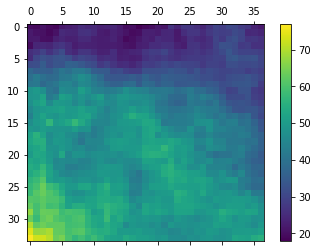

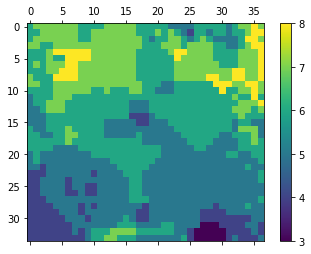

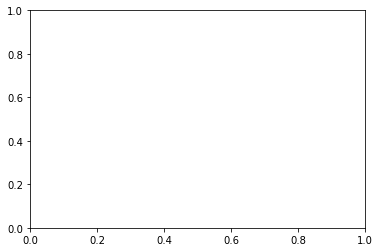

In [24]:
from matplotlib import pyplot
%matplotlib inline


fig0 = pyplot.figure()
ax0 = fig0.add_subplot(111)
cax0 = ax0.matshow(daily_sum)
fig0.colorbar(cax0)
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(no_value)
fig.colorbar(cax)
fig1 = pyplot.figure()
ax1 = fig1.add_subplot(111)
cax1 = ax1.matshow(count_above_one)
fig1.colorbar(cax1)





fig2 = pyplot.figure()
ax2 = fig2.add_subplot(111)
cax2 = ax2.matshow(longest_sequence)
fig2.colorbar(cax2)

pyplot.show()